<h1 align="center">Reorganizing the NFL</h1>
<h3 align="center">By Vade Kamenitsa-Hale and Steven Wood</h3>

## The Problem

In the NFL, teams must play the others in their division twice a year. Divisions are labeled “North”, “South”, “East”, and “West”, but teams are seemingly haphazardly organized. The cardinal directionally named divisions are a very broad generalization of team locations. For example in the AFC “East”, why are the New England Patriots in the same division as the Miami Dolphins, forcing them both to trek the entire eastern seaboard twice a year? 

These divisional groupings are vestiges of an ever evolving league. The additions and relocations of teams over the last 60 years has driven divisional groupings instead of using an optimal solution. Unnecessary travel time should be minimized as it’s taxing to players and the environment. This project’s purpose is to propose new divisional and conference groupings to minimize the travel time wasted in a season.

## Our Approach

Our solution was essentially an assignment problem, and we approached it as such using a graph structure. In our model, each of the 32 NFL teams is a node, and an edge is constructed between two teams if they are in the same division. There are 8 divisions. Five constraints were required before we were able to calculate the objective. The first constraint requires every team to participate in four games (including a game against themselves). The second constraint requires that each division is assigned to 16 matchups (4 per team). The third constraint is that each matchup appears up to one times across all divisions so that a matchup is not repeated in multiple divisions. The fourth constraint requires that each matchup is reflexive, so that both teams play each other. The last constraint ensures that each team has either 4 matchups or 0 matchups listed in each division. The resulting model sorts the teams into 8 groupings of 4 teams.

The objective function utilizes a distance parameter which describes the distance in miles between any two teams’ stadiums. The model’s goal is to minimize the total distance that teams travel to play their divisional games. That total is calculated as the sum of {2 * (distance from team1 to team2) } for all matchups that exist. This calculation is accurate because each matchup is listed twice, once as between team1 and team2, and once as between team2 and team1. Each team plays their divisional opponents twice per year and a team only must travel to one of those games, but to travel to a game and back is a travel distance twice as long as the listed distance. The games played between a team and itself in the model do not effect the objective because the distance traveled for such games is 0.

In [62]:
%load_ext gams_magic

The gams_magic extension is already loaded. To reload it, use:
  %reload_ext gams_magic


In [63]:
%gams_cleanup -k
%gams_reset

In [64]:
%%gams
set div /1*8/,
    teams;

$ call csv2gdx Coordinates.csv useHeader=y id=teams index=1
$gdxIn Coordinates.gdx
$load teams = teams
$gdxIn

parameter dist(teams, teams)
/
$ondelim
$include distances.csv
$offdelim
/;

alias(teams,teams2);
binary variable x(teams, teams2, div);
free variable totalDist;

equations
    matchups(teams,teams),
    games(teams),
    matchupReflex(teams,teams2,div),
    balanceDiv(div),
    sameDiv(teams,div),
    defObj
;

matchups(teams,teams2)..
    sum(div, x(teams,teams2,div)) =L= 1;
    
games(teams)..
    4 =E= sum((teams2,div), x(teams,teams2,div));
    
matchupReflex(teams,teams2,div)..
    x(teams,teams2,div) =E= x(teams2,teams,div);

balanceDiv(div)..
    sum((teams,teams2), x(teams,teams2,div)) =E= 16;
    
sameDiv(teams,div)..
    sum(teams2, x(teams,teams2,div)) =E= 4*x(teams,teams,div);
    
defObj..
    totalDist =E= sum((teams, teams2, div), 2*x(teams, teams2, div)*dist(teams,teams2));
    
model NflReorg /matchups, games, matchupReflex, balanceDiv, sameDiv, defObj/;

solve NflReorg using mip min totalDist;

parameter y(teams,div);

loop((teams,div) $ (x.l(teams,teams,div) > 0),
    y(teams,div) = 1;

);
display y;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Integer (8),70569.3535,9257,8193,MIP,CPLEX,179.714


# Results

With totally free assignment, we found that the following team groupings were optimal:

| D1      | D2     | D3        | D4          | D5     | D6        | D7       | D8        |
|---------|--------|-----------|-------------|--------|-----------|----------|-----------|
| Giants  | Cowboys| Steelers  | Vikings     | Bears  | Buccaneers| Titans   | Cardinals |
| Jets    | Saints | Ravens    | Broncos     | Packers| Falcons   | Panthers | Chargers  |
| Eagles  | Texans | Washington| Forty-Niners| Browns | Dolphins  | Colts    | Raiders   |
| Patriots| Chiefs | Bills     | Seahawks    | Lions  | Jaguars   | Bengals  | Rams      |

These groupings appear realistic. D4 is the largest group geographically, but due to a lack of teams on the western seaboard, this grouping is likely optimal. The total distance traveled totals just over 70,569 miles.

In [78]:
%gams_pull -d y
import geopandas
import matplotlib.pyplot as plt
import csv
%matplotlib inline

def findCityColor(z, team):
    for row in z.iterrows():
        if row[1][0] == team:
            return colors[int(row[1][1])]
    return 0

colors = ['', 'red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet', 'black']


world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
us = world[(world.pop_est>0) & (world.name=="United States of America")]
city = dict()
with open('Coordinates.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                line_count += 1
            else:
                city[row[0]] = [ float(row[3]), float(row[2])]
                line_count += 1 
                
def plot_division_layout(z, shouldDisplayText, size, title):
    us.plot(figsize=(size, size),color='white', edgecolor='black')
    for k, v in city.items():
        plt.scatter(*v, c=findCityColor(z, k),alpha=0.5)
        if shouldDisplayText:
            plt.text(*v, k)
    plt.xlim(-130,-60)
    plt.ylim(23,53)
    plt.title(title)
    return plt

Below is a map indicating the location of each team, and the divisional assignment of each team (by color):

<module 'matplotlib.pyplot' from '/Users/stevenwood/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

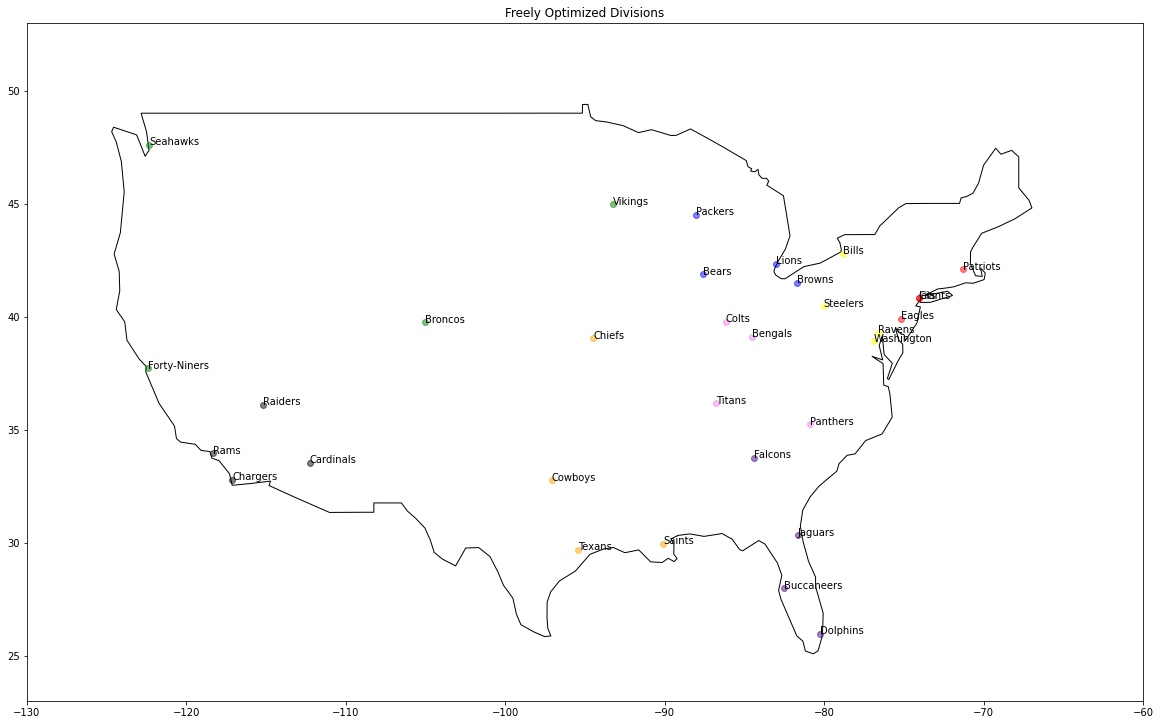

In [79]:
plot_division_layout(y, True, 20, "Freely Optimized Divisions")

Freely optimizing divisions eliminates many of the current rivalries that make the NFL so exciting. Thus, we also optimized the divisions keeping the most historied rivalries in-tact. 

In [67]:
%%gams
equations
    rivalry1,
    rivalry2
    rivalry3,
    rivalry4,
    rivalry5,
    rivalry6,
    rivalry7,
    rivalry8,
    rivalry9,
    rivalry10,
    sameStadium1,
    sameStadium2
;

rivalry1..
    sum(div, x("Packers","Bears",div)) =E= 1;
    
rivalry2..
    sum(div, x("Cowboys","Eagles",div)) =E= 1;
    
rivalry3..
    sum(div, x("Ravens","Steelers",div)) =E= 1;
    
rivalry4..
    sum(div, x("Chiefs","Raiders",div)) =E= 1;
    
rivalry5..
    sum(div, x("Washington","Giants",div)) =E= 1;
    
rivalry6..
    sum(div, x("Jets","Patriots",div)) =E= 1;
    
rivalry7..
    sum(div, x("Forty-Niners","Rams",div)) =E= 1;
    
rivalry8..
    sum(div, x("Bills","Dolphins",div)) =E= 1;
    
rivalry9..
    sum(div, x("Falcons","Saints",div)) =E= 1;
    
rivalry10..
    sum(div, x("Chargers","Broncos",div)) =E= 1;
    
sameStadium1..
    sum(div, x("Chargers","Rams",div)) =E= 0;

sameStadium2..
    sum(div, x("Giants","Jets",div)) =E= 0;

model rivals /all/;

solve rivals using mip min totalDist;

parameter r(teams,div);

loop((teams,div) $ (x.l(teams,teams,div) > 0),
    r(teams,div) = 1;

);
display r;


,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),99492.6224,9269,8193,MIP,CPLEX,28.699


In [68]:
%gams_pull -d r

As a basis of comparison, we also calculated the travel distance with the traditional standard divisional groupings:

In [69]:
%%gams
x.fx("Titans","Colts","1") = 1;
x.fx("Titans","Texans","1") = 1;
x.fx("Titans","Jaguars","1") = 1;
x.fx("Steelers","Browns","2") = 1;
x.fx("Steelers","Ravens","2") = 1;
x.fx("Steelers","Bengals","2") = 1;
x.fx("Chiefs","Raiders","3") = 1;
x.fx("Chiefs","Broncos","3") = 1;
x.fx("Chiefs","Chargers","3") = 1;
x.fx("Bills","Dolphins","4") = 1;
x.fx("Bills","Patriots","4") = 1;
x.fx("Bills","Jets","4") = 1;
x.fx("Giants","Washington","5") = 1;
x.fx("Giants","Eagles","5") = 1;
x.fx("Giants","Cowboys","5") = 1;
x.fx("Rams","Seahawks","6") = 1;
x.fx("Rams","Cardinals","6") = 1;
x.fx("Rams","Forty-Niners","6") = 1;
x.fx("Packers","Vikings","7") = 1;
x.fx("Packers","Bears","7") = 1;
x.fx("Packers","Lions","7") = 1;
x.fx("Saints","Buccaneers","8") = 1;
x.fx("Saints","Falcons","8") = 1;
x.fx("Saints","Panthers","8") = 1;

solve NflReorg using mip min totalDist;

parameter c(teams,div);

loop((teams,div) $ (x.l(teams,teams,div) > 0),
    c(teams,div) = 1;

);
display c;


,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),109294.664,9257,8193,MIP,CPLEX,0.046


In [70]:
%gams_pull -d c

# Conclusion

We can see that reorganizing the divisions to our model saves 38725 (or 35%) miles. This significantly reduces the NFL's ecological footprint (considering fans who travel as well) and can boost player performance from less travel. This can seen visually by the tighness of color distribution in the following graphs:

<module 'matplotlib.pyplot' from '/Users/stevenwood/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

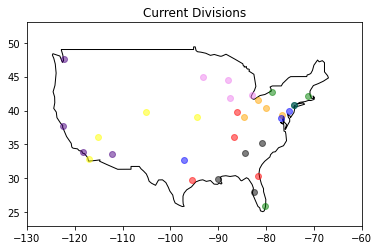

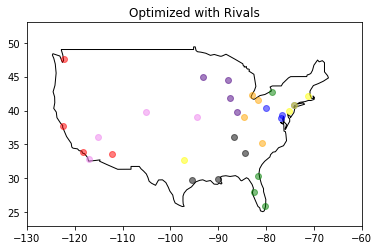

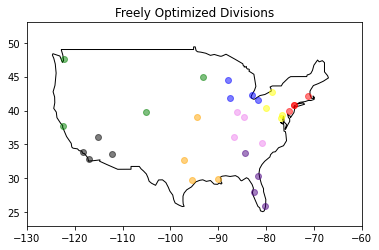

In [81]:
plot_division_layout(c, False, 6, 'Current Divisions')
plot_division_layout(r, False, 6, 'Optimized with Rivals')
plot_division_layout(y, False, 6, 'Freely Optimized Divisions')